# Convolutional Neural Net: Training, Validation, and Testing
By Fredi R. Mino

April 2021

In [1]:
version = 22

# Step 1
Import ```keras``` and any other libraries you might need for data manipulation.

In [2]:
import matplotlib.pyplot as plt
from tifffile import imread, imwrite
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import activations, datasets, layers, models
from keras.utils import to_categorical

from skimage.transform import resize
from sklearn.model_selection import train_test_split

## Step 2
Verify that you can load and display your TIFs

numpy.ndarray

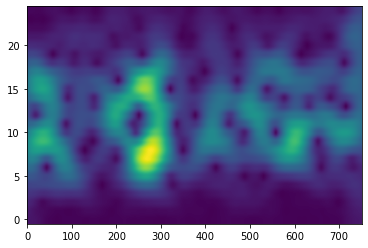

In [3]:
data = imread(f'./img_data/move_up/ses_01_run_01_7095.tif')
plt.imshow(data[:,:,5], aspect = 'auto')
plt.gca().invert_yaxis()
type(data)

## Step 3
Reshape your data to match the input of your CNN, and plot it to make sure that it looks the same as in the previous step

(25, 751, 8)
(64, 64, 8)


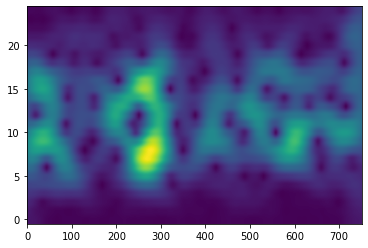

In [4]:
print(data.shape)

res_im = resize(data, (64,64,8))
print (res_im.shape)
plt.imshow(data[:,:,5], aspect='auto')
plt.gca().invert_yaxis()

In [5]:
def get_labels(image_data_path):
    labels = []
    dir_list = os.listdir(image_data_path)
    for i in range(len(dir_list)):
        labels.append(dir_list[i])
    return labels

In [6]:
print(get_labels('./img_data'))

['move_down', 'move_idle', 'move_left', 'move_right', 'move_up']


In [7]:
def load_images(labels, image_data_path, img_h, img_w):
    train_labels = np.zeros((0,1))
    
    for i in range(len(labels)):
        dir_path = image_data_path + '/' + labels[i]
        data_list = os.listdir(dir_path)
        
        for j in range(len(data_list)):
            img_in = imread(dir_path + '/' + data_list[j])
            res_img = resize(img_in, (64, 64, 8))
            res_img = np.reshape(res_img, (1, img_h, img_w, 8))
            if i == 0 and j == 0:
                train_imgs = res_img
            else:
                train_imgs = np.append(train_imgs, res_img, 0)
            train_labels = np.append(train_labels, np.array([[i]]), axis =0)
        print("Loaded all {} images".format(labels[i]))
    print("Done")
    return train_imgs, train_labels
            

In [8]:
class_labels = get_labels('./img_data')
imgs, labels = load_images(class_labels, './img_data', 64, 64)

Loaded all move_down images
Loaded all move_idle images
Loaded all move_left images
Loaded all move_right images
Loaded all move_up images
Done


In [9]:
print(imgs.shape)
print(labels.shape)
assert imgs.shape[0] == labels.shape[0]

(760, 64, 64, 8)
(760, 1)


Label code as loaded by load_data():
- 0: move_down
- 1: move_idle
- 2: move_left
- 3: move_right
- 4: move_up

In [10]:
print(class_labels)

['move_down', 'move_idle', 'move_left', 'move_right', 'move_up']


In [11]:
imgs_train, imgs_test, labels_train, labels_test = train_test_split(imgs, labels, test_size = 0.10)

In [12]:
print(imgs_train.shape)
print(labels_train.shape)
print(imgs_test.shape)
print(labels_test.shape)
print(labels_train[0])

(684, 64, 64, 8)
(684, 1)
(76, 64, 64, 8)
(76, 1)
[4.]


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((imgs_train, labels_train))

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(128, (3,3), input_shape = (64,64,8), data_format = "channels_last"))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Activation(activations.elu))
model.add(layers.Dropout(rate = 0.5))

model.add(layers.Conv2D(128, (3,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Activation(activations.elu))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.BatchNormalization(momentum = 0.6))

model.add(layers.Conv2D(64, (3,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Activation(activations.elu))
model.add(layers.Dropout(rate = 0.5))
model.add(layers.BatchNormalization(momentum = 0.6))

model.add(layers.Conv2D(32, (3,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Activation(activations.elu))
model.add(layers.Dropout(rate = 0.25))

model.add(layers.Flatten())

model.add(layers.Dense(100))
model.add(layers.Activation(activations.elu))
model.add(layers.Dropout(rate = 0.25))

model.add(layers.Dense(len(class_labels)))

In [15]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
             metrics=['accuracy'])

In [16]:
checkpoint_filepath = '.\tmp\checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [18]:
history = model.fit(imgs_train, 
                    labels_train, 
                    batch_size = 5, 
                    epochs = 350, 
                    validation_data = (imgs_test, labels_test), 
                    callbacks=[model_checkpoint_callback]
                   )

Epoch 1/350
137/137 [==============================] - 1s 4ms/step - loss: 2.5130 - accuracy: 0.1944 - val_loss: 1.7512 - val_accuracy: 0.2105
Epoch 2/350
137/137 [==============================] - 1s 4ms/step - loss: 2.3553 - accuracy: 0.2135 - val_loss: 1.7490 - val_accuracy: 0.2105
Epoch 3/350
137/137 [==============================] - 1s 4ms/step - loss: 2.4027 - accuracy: 0.2120 - val_loss: 1.7845 - val_accuracy: 0.2105
Epoch 4/350
137/137 [==============================] - 1s 4ms/step - loss: 2.3207 - accuracy: 0.1974 - val_loss: 1.8006 - val_accuracy: 0.2105
Epoch 5/350
137/137 [==============================] - 0s 4ms/step - loss: 2.2924 - accuracy: 0.1930 - val_loss: 1.7821 - val_accuracy: 0.2237
Epoch 6/350
137/137 [==============================] - 1s 4ms/step - loss: 2.2345 - accuracy: 0.2076 - val_loss: 1.7915 - val_accuracy: 0.2105
Epoch 7/350
137/137 [==============================] - 0s 4ms/step - loss: 2.2435 - accuracy: 0.1871 - val_loss: 1.8171 - val_accuracy: 0.2105

Epoch 58/350
137/137 [==============================] - 1s 4ms/step - loss: 1.4766 - accuracy: 0.3246 - val_loss: 1.5869 - val_accuracy: 0.3158
Epoch 59/350
137/137 [==============================] - 1s 4ms/step - loss: 1.4946 - accuracy: 0.3377 - val_loss: 1.5691 - val_accuracy: 0.3553
Epoch 60/350
137/137 [==============================] - 1s 4ms/step - loss: 1.4976 - accuracy: 0.3640 - val_loss: 1.6354 - val_accuracy: 0.3289
Epoch 61/350
137/137 [==============================] - 1s 4ms/step - loss: 1.4590 - accuracy: 0.3596 - val_loss: 1.6193 - val_accuracy: 0.3158
Epoch 62/350
137/137 [==============================] - 0s 4ms/step - loss: 1.4921 - accuracy: 0.3392 - val_loss: 1.6293 - val_accuracy: 0.3158
Epoch 63/350
137/137 [==============================] - 1s 4ms/step - loss: 1.4509 - accuracy: 0.3626 - val_loss: 1.5863 - val_accuracy: 0.3158
Epoch 64/350
137/137 [==============================] - 1s 4ms/step - loss: 1.4650 - accuracy: 0.3582 - val_loss: 1.5363 - val_accuracy:

Epoch 115/350
137/137 [==============================] - 0s 4ms/step - loss: 1.2833 - accuracy: 0.4547 - val_loss: 1.6212 - val_accuracy: 0.3026
Epoch 116/350
137/137 [==============================] - 0s 4ms/step - loss: 1.2516 - accuracy: 0.4488 - val_loss: 1.5819 - val_accuracy: 0.3289
Epoch 117/350
137/137 [==============================] - 1s 4ms/step - loss: 1.2837 - accuracy: 0.4342 - val_loss: 1.5887 - val_accuracy: 0.3421
Epoch 118/350
137/137 [==============================] - 1s 4ms/step - loss: 1.3163 - accuracy: 0.4196 - val_loss: 1.6564 - val_accuracy: 0.3026
Epoch 119/350
137/137 [==============================] - 0s 4ms/step - loss: 1.3116 - accuracy: 0.4342 - val_loss: 1.5966 - val_accuracy: 0.3289
Epoch 120/350
137/137 [==============================] - 1s 4ms/step - loss: 1.3278 - accuracy: 0.4108 - val_loss: 1.6001 - val_accuracy: 0.3421
Epoch 121/350
137/137 [==============================] - 1s 4ms/step - loss: 1.2764 - accuracy: 0.4386 - val_loss: 1.6695 - val_ac

137/137 [==============================] - 1s 4ms/step - loss: 1.1559 - accuracy: 0.5029 - val_loss: 1.6747 - val_accuracy: 0.3553
Epoch 172/350
137/137 [==============================] - 1s 4ms/step - loss: 1.1414 - accuracy: 0.5132 - val_loss: 1.6707 - val_accuracy: 0.3289
Epoch 173/350
137/137 [==============================] - 1s 4ms/step - loss: 1.1166 - accuracy: 0.5146 - val_loss: 1.7124 - val_accuracy: 0.3421
Epoch 174/350
137/137 [==============================] - 1s 4ms/step - loss: 1.1502 - accuracy: 0.5351 - val_loss: 1.6447 - val_accuracy: 0.3289
Epoch 175/350
137/137 [==============================] - 1s 4ms/step - loss: 1.1348 - accuracy: 0.5175 - val_loss: 1.6539 - val_accuracy: 0.3421
Epoch 176/350
137/137 [==============================] - 1s 4ms/step - loss: 1.1503 - accuracy: 0.5249 - val_loss: 1.7029 - val_accuracy: 0.3158
Epoch 177/350
137/137 [==============================] - 1s 4ms/step - loss: 1.1532 - accuracy: 0.4868 - val_loss: 1.6737 - val_accuracy: 0.3421

137/137 [==============================] - 0s 4ms/step - loss: 0.9685 - accuracy: 0.5877 - val_loss: 1.7444 - val_accuracy: 0.3816
Epoch 228/350
137/137 [==============================] - 1s 4ms/step - loss: 0.9490 - accuracy: 0.5950 - val_loss: 1.8168 - val_accuracy: 0.3421
Epoch 229/350
137/137 [==============================] - 0s 3ms/step - loss: 0.9913 - accuracy: 0.5760 - val_loss: 1.8401 - val_accuracy: 0.3421
Epoch 230/350
137/137 [==============================] - 0s 4ms/step - loss: 0.9674 - accuracy: 0.5863 - val_loss: 1.6931 - val_accuracy: 0.3816
Epoch 231/350
137/137 [==============================] - 1s 4ms/step - loss: 0.9417 - accuracy: 0.6140 - val_loss: 1.7433 - val_accuracy: 0.3553
Epoch 232/350
137/137 [==============================] - 1s 4ms/step - loss: 1.0012 - accuracy: 0.5687 - val_loss: 1.7519 - val_accuracy: 0.3289
Epoch 233/350
137/137 [==============================] - 0s 4ms/step - loss: 1.0014 - accuracy: 0.5775 - val_loss: 1.7121 - val_accuracy: 0.3421

137/137 [==============================] - 0s 4ms/step - loss: 0.7815 - accuracy: 0.6813 - val_loss: 1.8152 - val_accuracy: 0.3947
Epoch 284/350
137/137 [==============================] - 1s 4ms/step - loss: 0.8147 - accuracy: 0.6594 - val_loss: 1.8775 - val_accuracy: 0.3947
Epoch 285/350
137/137 [==============================] - 1s 5ms/step - loss: 0.7675 - accuracy: 0.6857 - val_loss: 1.8468 - val_accuracy: 0.3816
Epoch 286/350
137/137 [==============================] - 1s 10ms/step - loss: 0.8052 - accuracy: 0.6725 - val_loss: 1.8190 - val_accuracy: 0.4474
Epoch 287/350
137/137 [==============================] - 1s 6ms/step - loss: 0.7803 - accuracy: 0.6725 - val_loss: 1.7794 - val_accuracy: 0.4211
Epoch 288/350
137/137 [==============================] - 0s 4ms/step - loss: 0.8039 - accuracy: 0.6813 - val_loss: 1.9148 - val_accuracy: 0.3947
Epoch 289/350
137/137 [==============================] - 0s 4ms/step - loss: 0.7962 - accuracy: 0.6944 - val_loss: 1.7968 - val_accuracy: 0.381

137/137 [==============================] - 1s 4ms/step - loss: 0.6015 - accuracy: 0.7822 - val_loss: 1.8042 - val_accuracy: 0.4342
Epoch 340/350
137/137 [==============================] - 0s 4ms/step - loss: 0.5749 - accuracy: 0.7734 - val_loss: 1.9259 - val_accuracy: 0.4342
Epoch 341/350
137/137 [==============================] - 1s 6ms/step - loss: 0.6362 - accuracy: 0.7412 - val_loss: 1.9143 - val_accuracy: 0.4474
Epoch 342/350
137/137 [==============================] - 1s 10ms/step - loss: 0.6097 - accuracy: 0.7807 - val_loss: 1.9938 - val_accuracy: 0.4211
Epoch 343/350
137/137 [==============================] - 1s 10ms/step - loss: 0.6147 - accuracy: 0.7515 - val_loss: 1.9510 - val_accuracy: 0.4079
Epoch 344/350
137/137 [==============================] - 1s 10ms/step - loss: 0.6313 - accuracy: 0.7602 - val_loss: 1.9405 - val_accuracy: 0.4079
Epoch 345/350
137/137 [==============================] - 1s 10ms/step - loss: 0.5919 - accuracy: 0.7558 - val_loss: 1.9184 - val_accuracy: 0.

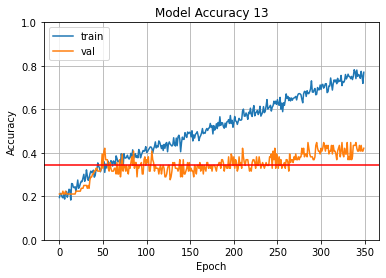

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axhline(y=np.mean(history.history['val_accuracy']), color='r')
plt.title('Model Accuracy 13')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim([0, 1])
plt.grid()

fig = plt.gcf()
plt.show()

fig.savefig("model_accuracy_{:02d}.jpeg".format(version), dpi = 200)

In [20]:
model.load_weights(checkpoint_filepath)
model.save("classifier_{:02d}_v3".format(version))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: classifier_22_v3\assets


In [21]:
results = model.evaluate(imgs_test, labels_test)
print("test loss, test acc: ", results)

3/3 [==============================] - 0s 56ms/step - loss: 1.8190 - accuracy: 0.4474
test loss, test acc:  [1.8190151453018188, 0.44736841320991516]


In [23]:
res_data = resize(data, (64, 64, 8))
res_data = np.reshape(res_data, (1, 64, 64, 8))
model.predict(res_data)

array([[ 0.57927275, -2.9233744 ,  2.6826024 ,  1.318293  ,  1.4435011 ]],
      dtype=float32)